# Team 1
* Siddharth Pant
* Rohan Gupta
* Sagar Dawda

# Problem Statement(#4)
## Predict bankruptcy of a Polish Company

In [23]:
# %load /home/sid/libs.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.io.arff import loadarff
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
%matplotlib inline

/home/sid/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_raw_data(*files):
    test_data = [pd.DataFrame(loadarff(file)[0]) for file in files]
    for i in range(len(test_data)):
        test_data[i]['class'].replace([b'0', b'1'], [0, 1], inplace = True)
    return test_data
test_df = get_raw_data('data/1year.arff', 'data/2year.arff', 'data/3year.arff', 'data/4year.arff', 'data/5year.arff')

In [3]:
def test_train_splitter(data):
    X_train_2 = []
    X_test_2 = []
    y_train_2 = []
    y_test_2 = []
    X_val_2 = []
    y_val_2 = []
    for i in range(len(data)):
        X, y = data[i].iloc[:,:-1], data[i]['class']
        X.drop(['Attr37', 'Attr21'], axis=1, inplace=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
        X_train.fillna(X_train.median(), inplace=True)
        X_test.fillna(X_test.median(), inplace=True)
#         Q3 = X_train.quantile(0.75)
#         Q1 = X_train.quantile(0.25)
#         IQR = Q3 - Q1
#         min = Q1 - 1.5 * IQR
#         max = Q3 + 1.5 * IQR
#         for col in X_train.columns:
#             X_train[col][X_train[col] < min[col]] = min[col]
#             X_train[col][X_train[col] > max[col]] = max[col]
        X_train_v, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 9)
        X_train_2.append(X_train_v)
        X_test_2.append(X_test)
        y_train_2.append(y_train)
        y_test_2.append(y_test)
        X_val_2.append(X_val)
        y_val_2.append(y_val)
    X_train_fin = pd.concat(X_train_2)
    X_test_fin = pd.concat(X_test_2)
    y_train_fin = pd.concat(y_train_2)
    y_test_fin = pd.concat(y_test_2)
    X_val_fin = pd.concat(X_val_2)
    y_val_fin = pd.concat(y_val_2)
    return X_train_fin, X_test_fin, X_val_fin, y_test_fin, y_train_fin, y_val_fin
        
X_train, X_test, X_val, y_test, y_train, y_val  = test_train_splitter(test_df)
X_train = X_train.reset_index(drop=True).copy()
X_test = X_test.reset_index(drop=True).copy()
y_test = y_test.reset_index(drop=True).copy()
y_train = y_train.reset_index(drop=True).copy()
X_val = X_val.reset_index(drop=True).copy()
y_val = y_val.reset_index(drop=True).copy()


/home/sid/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


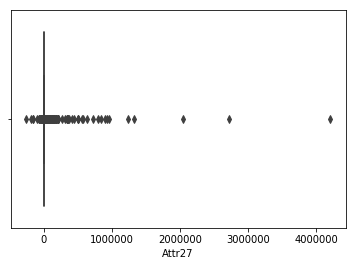

In [35]:
sns.boxplot(X_train['Attr27'])

/home/sid/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


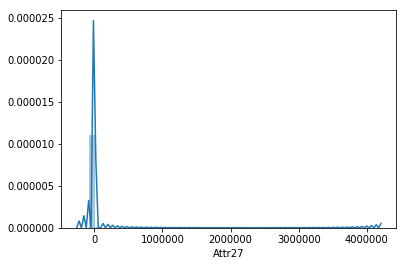

In [36]:
sns.distplot(X_train['Attr27'])

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((31247, 62), (31247,), (8683, 62), (8683,), (3475, 62), (3475,))

In [5]:
y_train.value_counts()

0    29720
1     1527
Name: class, dtype: int64

In [6]:
y_test.value_counts()

0    8242
1     441
Name: class, dtype: int64

In [7]:
y_val.value_counts()

0    3352
1     123
Name: class, dtype: int64

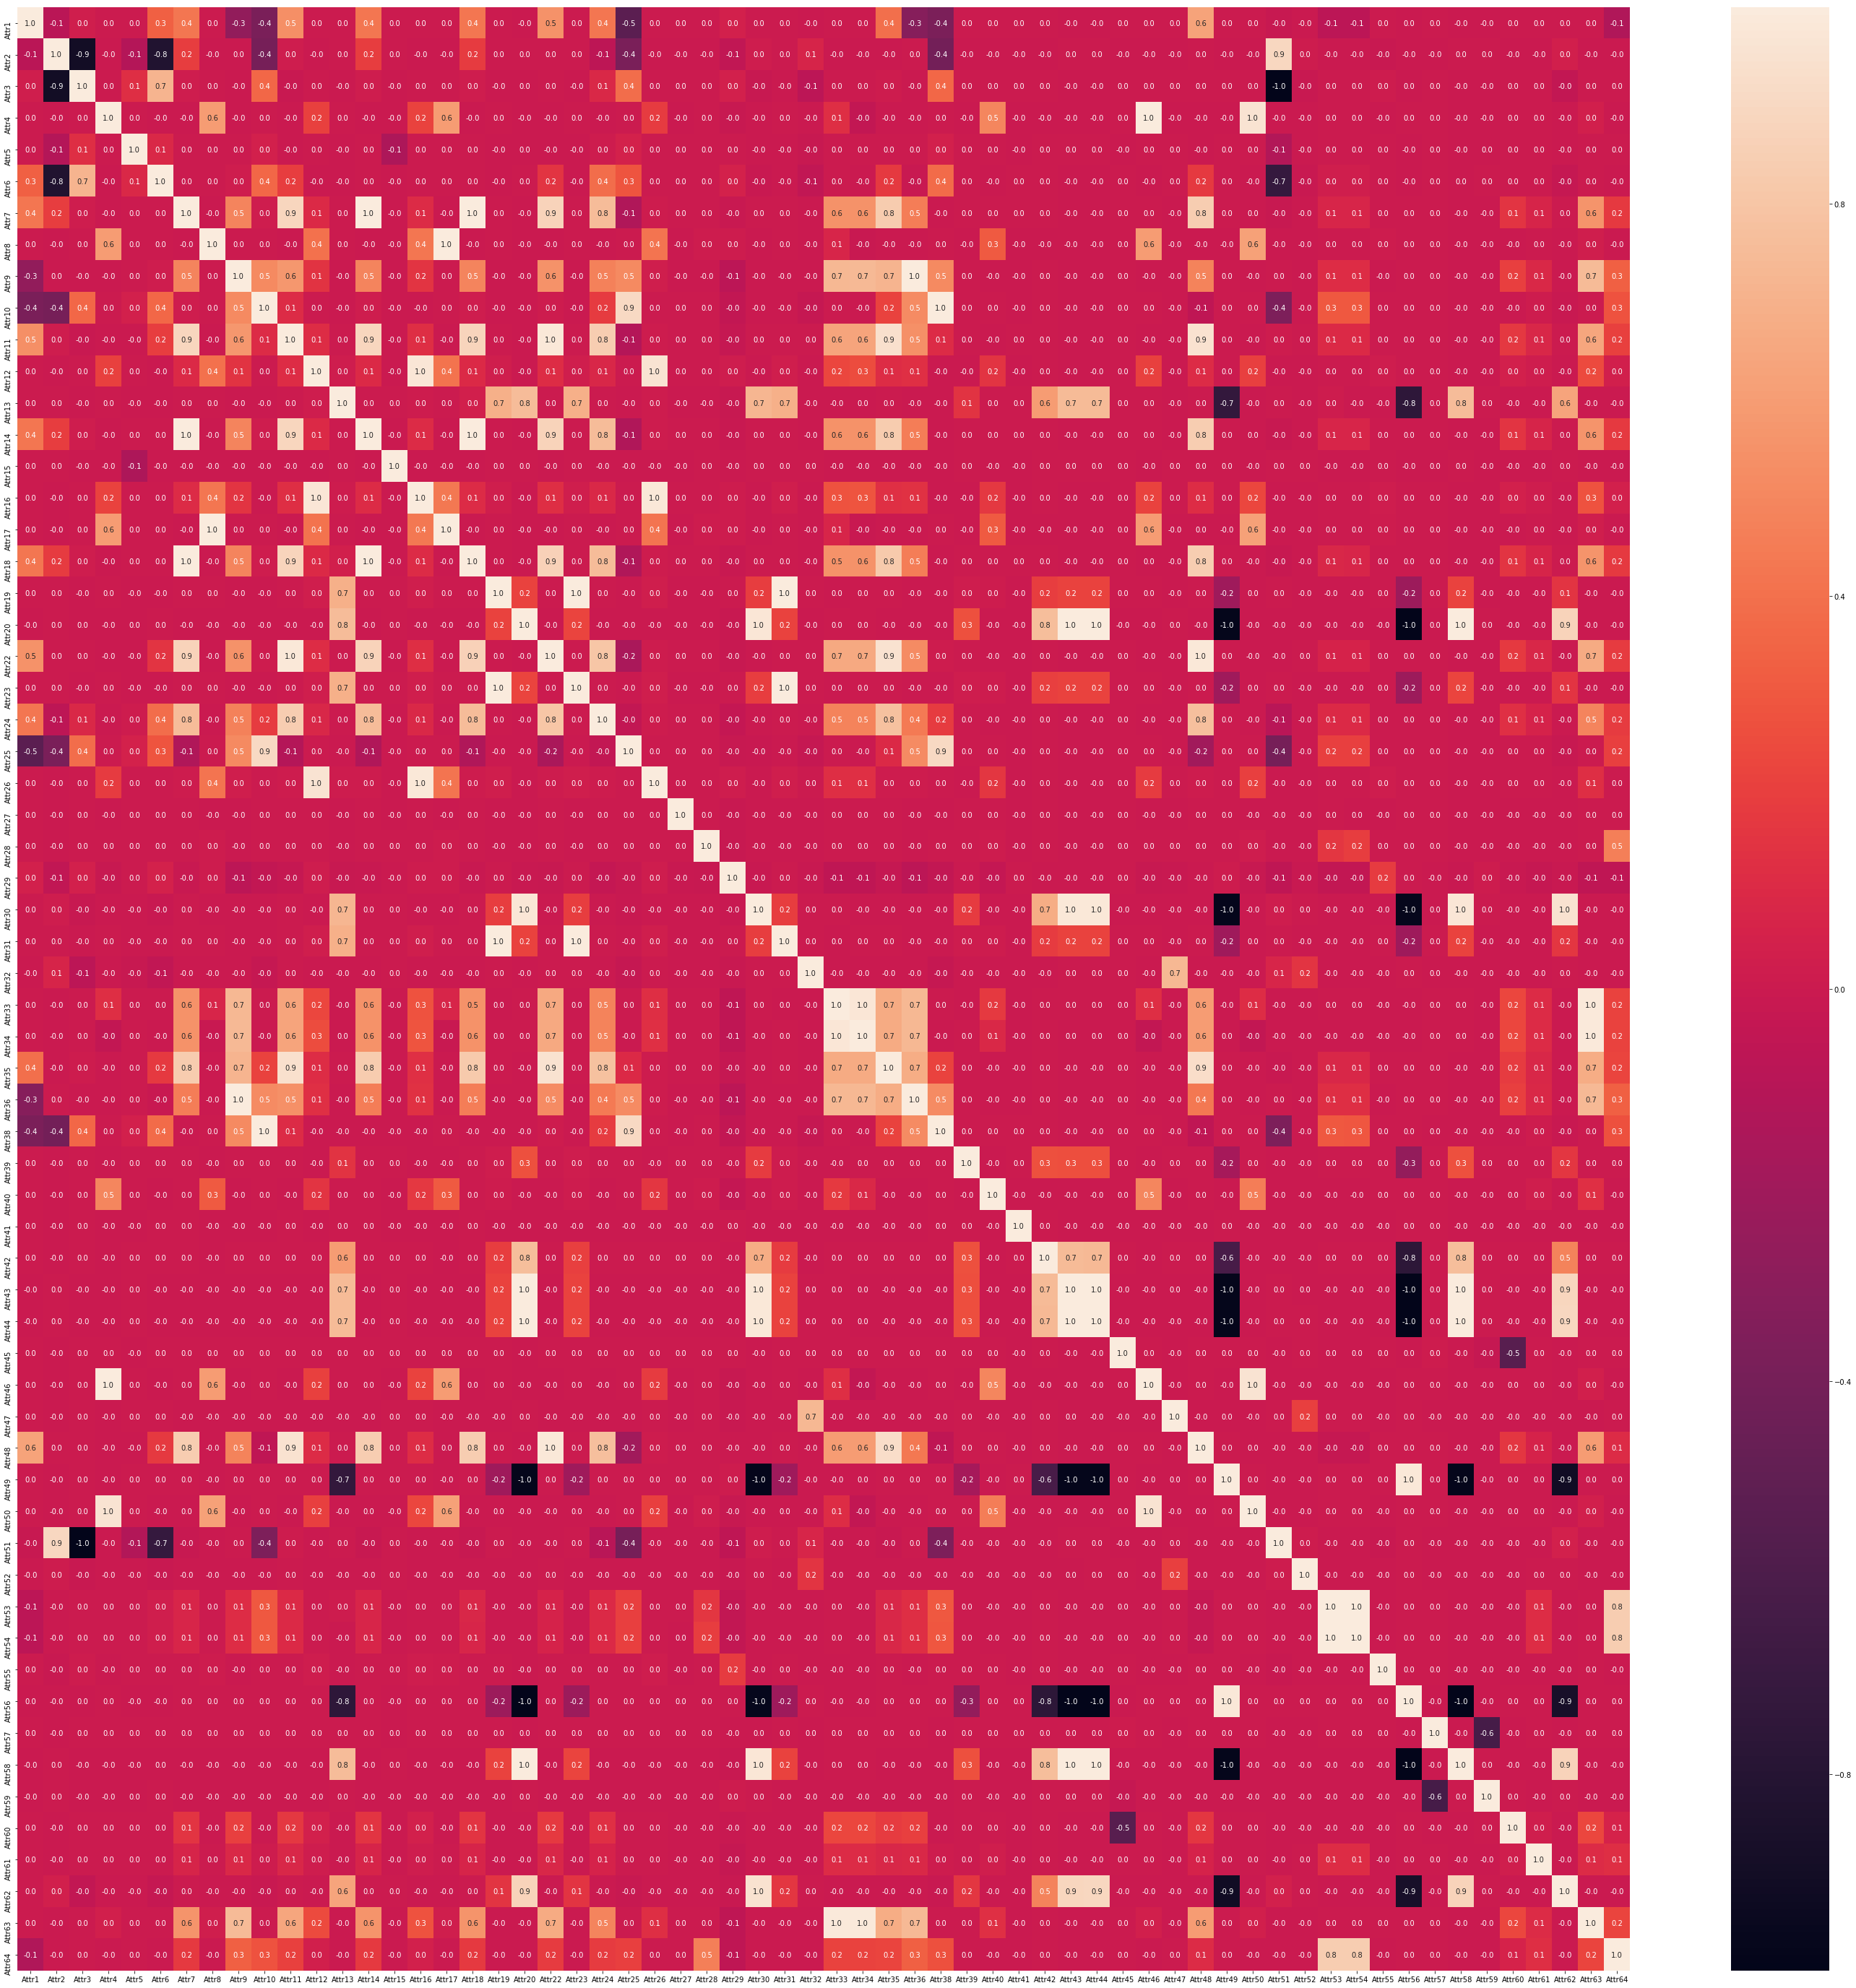

In [21]:
plt.figure(figsize=(50,50))
corr = X_train.corr()
sns.heatmap(corr, annot=True,fmt='.1f')
plt.show()

In [8]:
def get_me_mah_model(X_train, y_train, X_test, y_test, Model):
    model = Model(random_state=9)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print "Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred) * 100)
    print "f1_score", f1_score(y_test, y_pred)
    print "precision_score", precision_score(y_test, y_pred)
    print "recall_score", recall_score(y_test, y_pred)
    print "roc_auc_score", roc_auc_score(y_test, y_pred)
    print "cm matrix", confusion_matrix(y_test, y_pred)
    scores = [n for m, n in model.predict_proba(X_test)]
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    plt.plot(fpr, tpr)
    plt.plot([(0,0), (1,1)])
    len(y_test[y_test == 1])
    return model

In [9]:
def get_me_rf_model(X_train, y_train, X_test, y_test, Model):    
    model = RandomForestClassifier(random_state=9, n_estimators=100, n_jobs=-1)
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test)
    print "Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred) * 100)
    print "f1_score", f1_score(y_test, y_pred)
    print "precision_score", precision_score(y_test, y_pred)
    print "recall_score", recall_score(y_test, y_pred)
    print "roc_auc_score", roc_auc_score(y_test, y_pred)
    print "cm matrix", confusion_matrix(y_test, y_pred)
    scores = [n for m, n in model.predict_proba(X_test)]
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    plt.plot(fpr, tpr)
    plt.plot([(0,0), (1,1)])
    print len(y_test[y_test == 1]),len(y_pred[y_pred == 1])
    return model

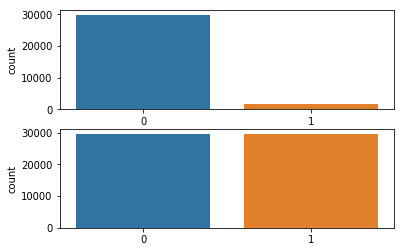

In [10]:
smote = SMOTE(random_state=9, kind = 'borderline2')
X_smote, y_smote = smote.fit_sample(X_train, y_train)
X_smote_val, y_smote_val = smote.fit_sample(X_val, y_val)
fig, (ax1,ax2) = plt.subplots(2, 1)
sns.countplot(y_smote, ax=ax2)
sns.countplot(y_train, ax=ax1)
plt.show()

Accuracy: 74.24%
f1_score 0.169327887115
precision_score 0.101243339254
recall_score 0.517006802721
roc_auc_score 0.635717669742
cm matrix [[6218 2024]
 [ 213  228]]


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=9, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

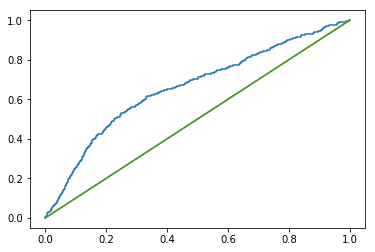

In [11]:
get_me_mah_model(X_smote, y_smote, X_test, y_test, LogisticRegression)

Accuracy: 94.61%
f1_score 0.459584295612
precision_score 0.468235294118
recall_score 0.451247165533
roc_auc_score 0.711913318268
cm matrix [[8016  226]
 [ 242  199]]
441 425


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

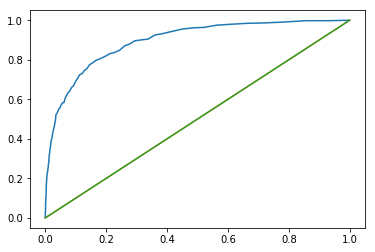

In [12]:
get_me_rf_model(X_smote, y_smote, X_test, y_test, RandomForestClassifier)

Accuracy: 94.61%
f1_score 0.459584295612
precision_score 0.468235294118
recall_score 0.451247165533
roc_auc_score 0.711913318268
cm matrix [[8016  226]
 [ 242  199]]
441 425


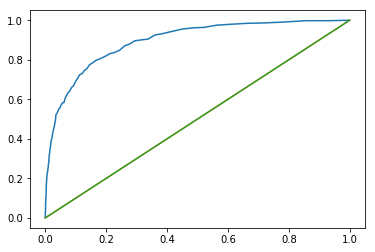

In [13]:
model = `get_me_rf_model(X_smote_val, y_smote_val, X_test, y_test, RandomForestClassifier)

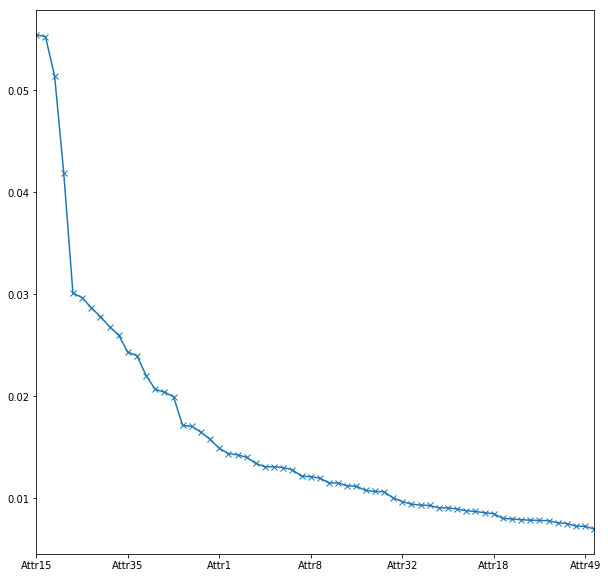

In [14]:
model.feature_importances_[np.argsort(model.feature_importances_)]
features_imp = pd.Series(data=model.feature_importances_, index=X_test.columns)
sorted_features = features_imp.sort_values(ascending=False)
plt.figure(figsize=(10,10))
sorted_features.plot(marker='x')

In [60]:
selected_features = sorted_features[sorted_features > 0.01]
df = pd.read_csv('array.csv', index_col=0)
l = [str(s) for s in selected_features.index]
df.loc[l]

,description
code,
Attr15,(total liabilities * 365) / (gross profit + d...
Attr27,profit on operating activities / financial ex...
Attr41,total liabilities / ((profit on operating act...
Attr6,\tretained earnings / total assets
Attr39,profit on sales / sales
Attr13,(gross profit + depreciation) / sales
Attr34,operating expenses / total liabilities
Attr16,(gross profit + depreciation) / total liabili...
Attr26,(net profit + depreciation) / total liabilities


In [25]:
X_smote2 = pd.DataFrame(data=X_smote, columns=X_train.columns)[selected_features.index].copy()
X_test2 = X_test[selected_features.index].copy()
X_smote_val2 = pd.DataFrame(data=X_smote_val, columns=X_val.columns)[selected_features.index].copy()

In [17]:
X_smote2.shape, X_test2.shape

((59439, 40), (8683, 40))

In [31]:
model = RandomForestClassifier(random_state=9, n_estimators=100, n_jobs=-1, min_samples_leaf=100)
model.fit(X_smote2, y_smote)
y_pred = model.predict(X_test2)
print "Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred) * 100)
print "f1_score", f1_score(y_test, y_pred)
print "precision_score", precision_score(y_test, y_pred)
print "recall_score", recall_score(y_test, y_pred)
print "roc_auc_score", roc_auc_score(y_test, y_pred)
print "cm matrix", confusion_matrix(y_test, y_pred)
scores = [n for m, n in model.predict_proba(X_test2)]
fpr, tpr, thresholds = roc_curve(y_test, scores)

Accuracy: 87.32%
f1_score 0.346587537092
precision_score 0.234726688103
recall_score 0.662131519274
roc_auc_score 0.773312787058
cm matrix [[7290  952]
 [ 149  292]]


441 1244


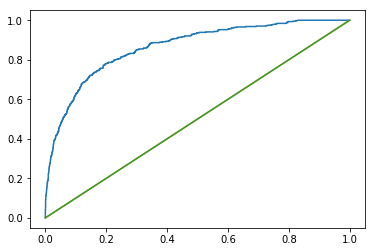

In [32]:
plt.plot(fpr, tpr)
plt.plot([(0,0), (1,1)])
print len(y_test[y_test == 1]),len(y_pred[y_pred == 1])

In [33]:
model = XGBClassifier()
eval_set = [(X_smote_val2, y_smote_val)]
model.fit(X_smote2, y_smote, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False)
y_pred = model.predict(X_test2)
print "Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred) * 100)
print "F1_score: ", f1_score(y_test, y_pred)
print "precision_score", precision_score(y_test, y_pred)
print "recall_score", recall_score(y_test, y_pred)
print "roc_auc_score", roc_auc_score(y_test, y_pred)
print "cm matrix", confusion_matrix(y_test, y_pred)
scores = [n for m, n in model.predict_proba(X_test2)]
fpr, tpr, thresholds = roc_curve(y_test, scores)


Accuracy: 88.18%
F1_score:  0.355527638191
precision_score 0.245873153779
recall_score 0.641723356009
roc_auc_score 0.768204555947
cm matrix [[7374  868]
 [ 158  283]]


(441, 1151)

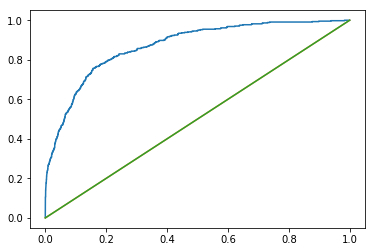

In [34]:
plt.plot(fpr, tpr)
plt.plot([(0,0), (1,1)])
len(y_test[y_test == 1]), len(y_pred[y_pred == 1])

# Questions and Answers